# Install

In [1]:
# pip install prophet

In [2]:
from prophet import Prophet

# Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import plotly.express as px
import itertools

#TimeSeries
from prophet import Prophet #case sensitive, needs to be Prophet with capital "P"
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',200)
pd.set_option('display.width',1000)

# Load Datasets

In [4]:
# Vamos importar a base para o nosso notebook e dar uma primeira "olhada" nos dados:
ts_raw = pd.read_csv('https://raw.githubusercontent.com/abnr/ml-data/main/stocks_ABBV.csv', index_col=[0])
ts_raw

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-11-23,85.599998,86.550003,84.900002,85.629997,78.807220,1612800
1,2013-12-24,52.779999,52.790001,52.279999,52.360001,40.406071,1747000
2,2019-12-24,90.400002,90.400002,89.430000,89.849998,88.652267,1798800
3,2017-12-28,98.190002,98.389999,97.519997,97.790001,86.620544,1870400
4,2017-12-27,97.730003,98.230003,97.440002,98.089996,86.886284,1927300
...,...,...,...,...,...,...,...
1820,2015-10-22,53.880001,54.439999,45.450001,48.270000,39.716072,46517700
1821,2015-03-05,57.209999,59.480000,56.650002,56.860001,45.636005,47051800
1822,2014-10-16,55.799999,55.900002,52.840000,52.900002,42.141338,61236700
1823,2019-06-25,70.470001,70.669998,65.059998,65.699997,62.018341,90131800


# Prophet
* https://facebook.github.io/prophet/docs/

In [5]:
# Vamos separar agora apenas os dados de fechamento, e estuda-la como uma série temporal
ts = ts_raw[['Date', 'Close']].copy()

# Renomeando as features para o padrão exigido pelo prophet
ts.rename(columns = {'Date':'ds',
                     'Close':'y'}, inplace = True)

#transformando ds para datetime
ts['ds'] = pd.to_datetime(ts['ds'])
ts = ts.sort_values('ds')
display(ts.head())
display(ts.tail())

,ds,y
1676,2013-01-02,35.119999
1743,2013-01-03,34.830002
1792,2013-01-04,34.389999
1759,2013-01-07,34.459999
1757,2013-01-08,33.709999


,ds,y
1730,2020-03-26,73.830002
1613,2020-03-27,72.669998
1508,2020-03-30,75.239998
1785,2020-03-31,76.190002
1648,2020-04-01,73.419998


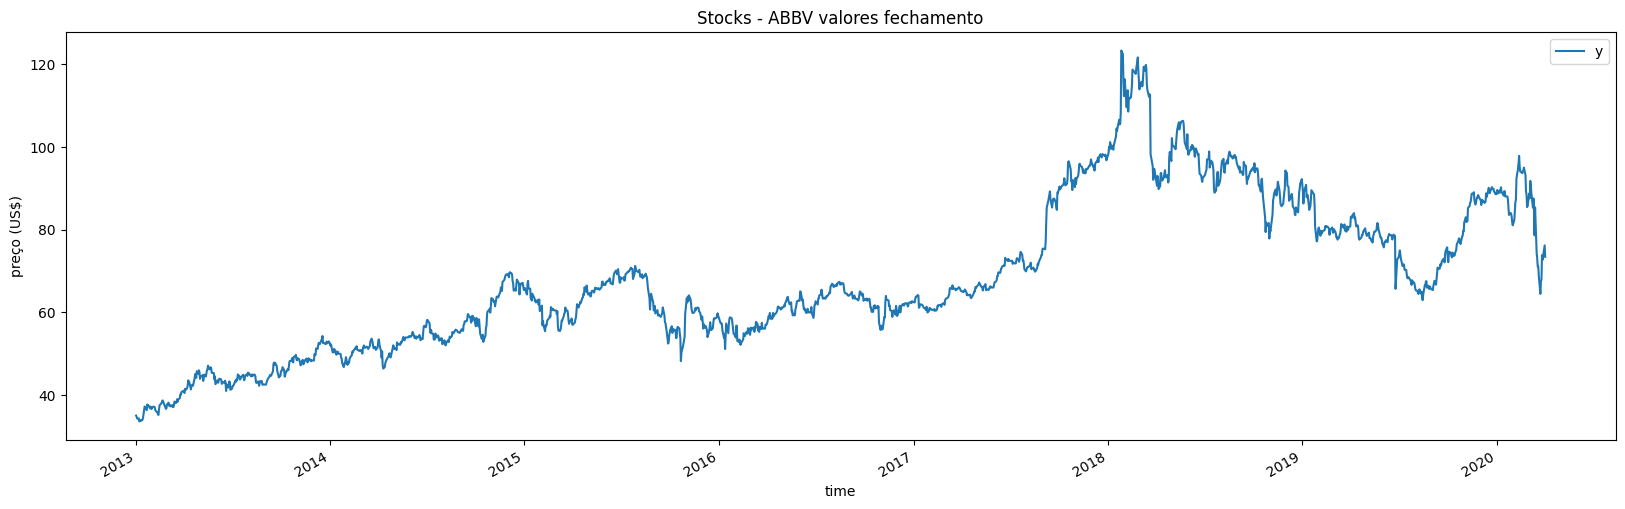

In [6]:
df_plot = ts.copy()
df_plot.set_index('ds', inplace = True)
df_plot.plot(figsize=(20, 6))

plt.title('Stocks - ABBV valores fechamento')
plt.ylabel('preço (US$)')
plt.xlabel('time');

# Modeling

## Utilizando o df completo para o fit do modelo

In [7]:
display(ts.shape)
display('Tail do dataframe original: ',ts.tail() )

(1825, 2)

'Tail do dataframe original: '

,ds,y
1730,2020-03-26,73.830002
1613,2020-03-27,72.669998
1508,2020-03-30,75.239998
1785,2020-03-31,76.190002
1648,2020-04-01,73.419998


In [8]:
#instanciando o modelo
m = Prophet()
m.fit(ts)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5hu7go5/yaiissga.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5hu7go5/lcqrp9s6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58710', 'data', 'file=/tmp/tmpz5hu7go5/yaiissga.json', 'init=/tmp/tmpz5hu7go5/lcqrp9s6.json', 'output', 'file=/tmp/tmpz5hu7go5/prophet_model33qf2lhn/prophet_model-20231006215554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:55:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:55:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [9]:
#criando os timestamps futuros para receber as previsões
future = m.make_future_dataframe(periods=270, include_history=False)
print('Forecast excluindo histórico de treinamento: ', future.shape)
display('Head dos primeiros 5 timestamps de 270 no total: ', future.head())

future = m.make_future_dataframe(periods=270, include_history=True)
print('\nForecast incluindo histórico: ', future.shape)
display('Tail dos últimos 5 timestamps de 270 no total: ', future.tail())

Forecast excluindo histórico de treinamento:  (270, 1)


'Head dos primeiros 5 timestamps de 270 no total: '

,ds
0,2020-04-02
1,2020-04-03
2,2020-04-04
3,2020-04-05
4,2020-04-06



Forecast incluindo histórico:  (2095, 1)


'Tail dos últimos 5 timestamps de 270 no total: '

,ds
2090,2020-12-23
2091,2020-12-24
2092,2020-12-25
2093,2020-12-26
2094,2020-12-27


In [10]:
#gerando as previsões para os timestamps criados na célula anterior
forecast = m.predict(future)
display('Tail das últimas 5 previsões: ', forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

'Tail das últimas 5 previsões: '

,ds,yhat,yhat_lower,yhat_upper
2090,2020-12-23,75.804648,65.385726,86.753098
2091,2020-12-24,75.848867,65.929253,86.949574
2092,2020-12-25,75.981645,65.632424,87.180875
2093,2020-12-26,74.819650,64.351249,86.567203
2094,2020-12-27,74.799091,64.849498,85.910448


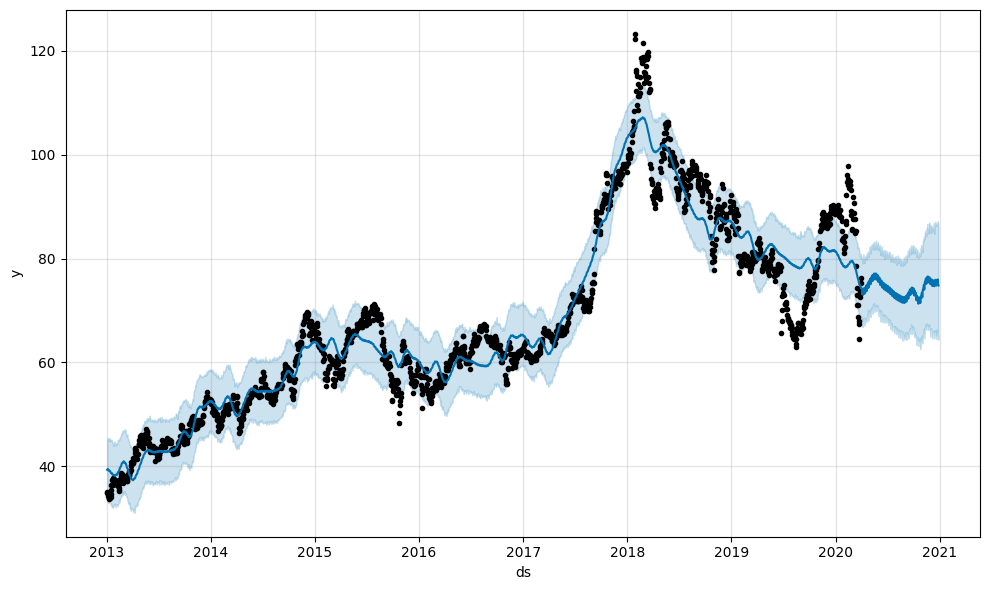

In [11]:
fig1 = m.plot(forecast)

'\nweekly_start Integer specifying the start day of the weekly seasonality plot. 0 (default) starts\nthe week on Sunday. 1 shifts by 1 day to Monday, and so on.\n\nyearly_start Integer specifying the start day of the yearly seasonality plot. 0 (default) starts\nthe year on Jan 1. 1 shifts by 1 day to Jan 2, and so on\n'

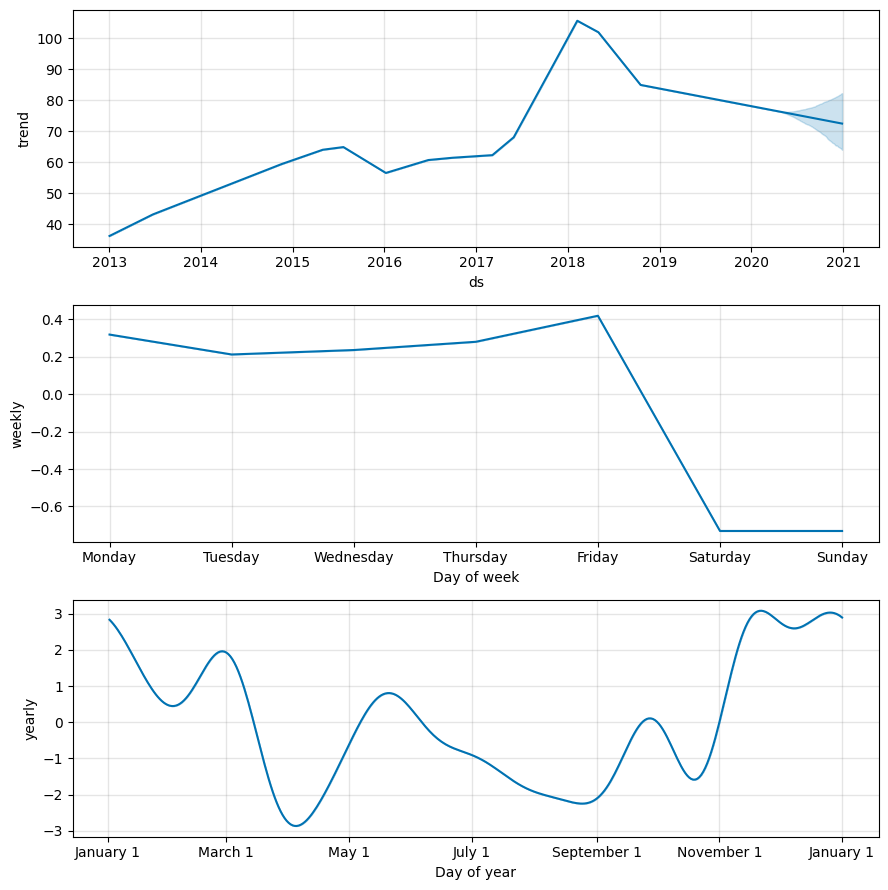

In [12]:
#componentes
fig2 = m.plot_components( forecast,
                          uncertainty = True,
                          plot_cap = True,
                          weekly_start = 1,
                          yearly_start = 1,
                          )
'''
weekly_start Integer specifying the start day of the weekly seasonality plot. 0 (default) starts
the week on Sunday. 1 shifts by 1 day to Monday, and so on.

yearly_start Integer specifying the start day of the yearly seasonality plot. 0 (default) starts
the year on Jan 1. 1 shifts by 1 day to Jan 2, and so on
'''

In [13]:
#componentes com plotly
from prophet.plot import plot_plotly, plot_components_plotly

fig1 = plot_plotly(m, forecast)
fig1.show()

fig2 = plot_components_plotly(m, forecast)
fig2.show()

# Changepoints
* Séries temporais reais frequentemente apresentam mudanças abruptas em suas trajetórias. Por padrão, o Prophet detectará automaticamente esses pontos de mudança e permitirá que a tendência se adapte adequadamente.

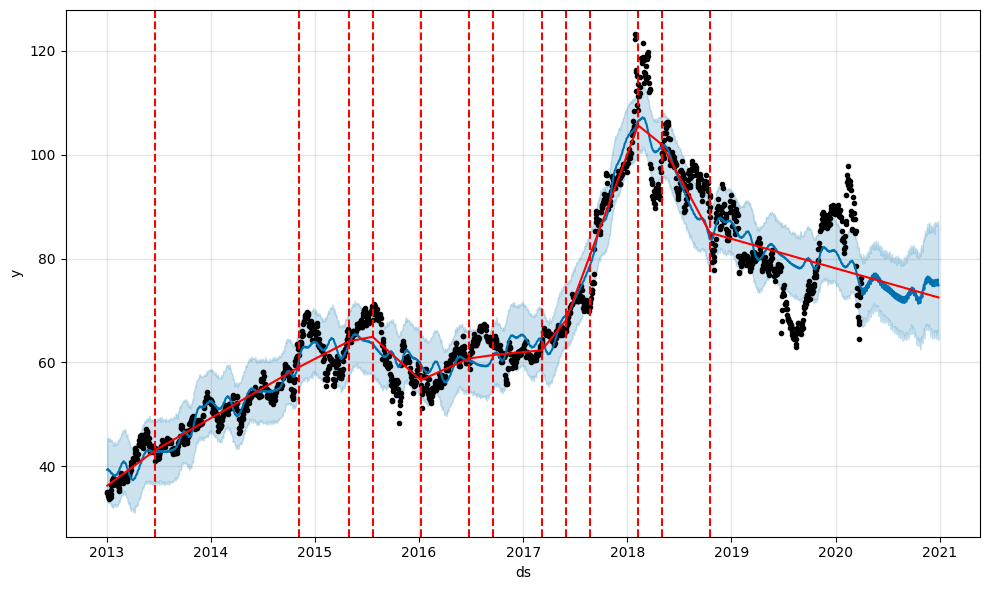

In [14]:
#changepoints

from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5hu7go5/5700m6ej.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5hu7go5/g1ce8_ln.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19555', 'data', 'file=/tmp/tmpz5hu7go5/5700m6ej.json', 'init=/tmp/tmpz5hu7go5/g1ce8_ln.json', 'output', 'file=/tmp/tmpz5hu7go5/prophet_model1gidjlsg/prophet_model-20231006215559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:55:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:56:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


'\nO parâmetro changepoint_prior_scale é um hiperparâmetro importante no contexto do Prophet, que é uma ferramenta de previsão de séries temporais desenvolvida pelo Facebook. Esse parâmetro controla a flexibilidade do modelo na detecção de mudanças abruptas nos dados de séries temporais.\nEm essência, ele controla a penalização aplicada às mudanças na tendência da série temporal.\n\nAqui estão os detalhes de como o parâmetro changepoint_prior_scale afeta o modelo Prophet:\n\nValores Baixos: Quando você define um valor baixo para changepoint_prior_scale, o modelo será mais conservador na detecção de mudanças.\nIsso significa que ele considerará menos pontos de dados como pontos de virada significativos na série temporal.\nO resultado pode ser um modelo que se ajusta melhor a séries temporais com mudanças suaves e graduais na tendência.\n\nValores Elevados: Por outro lado, se você definir um valor alto para changepoint_prior_scale, o modelo será mais flexível na detecção de mudanças.\nEl

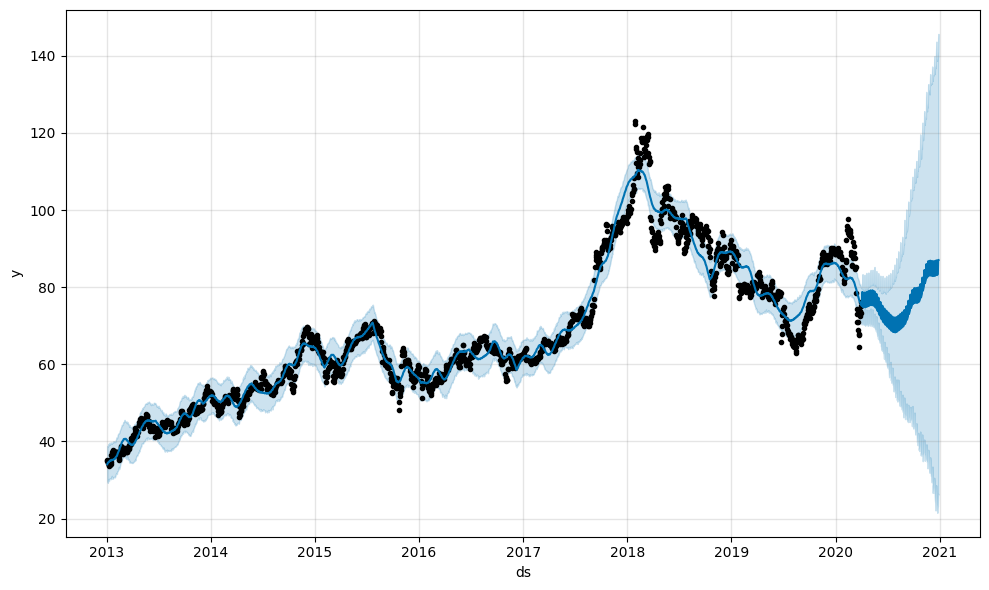

In [15]:
# changepoint_prior_scale = 0.5
m = Prophet(changepoint_prior_scale=0.5)
forecast = m.fit(ts).predict(future)
fig = m.plot(forecast)

'''
O parâmetro changepoint_prior_scale é um hiperparâmetro importante no contexto do Prophet, que é uma ferramenta de previsão de séries temporais desenvolvida pelo Facebook. Esse parâmetro controla a flexibilidade do modelo na detecção de mudanças abruptas nos dados de séries temporais.
Em essência, ele controla a penalização aplicada às mudanças na tendência da série temporal.

Aqui estão os detalhes de como o parâmetro changepoint_prior_scale afeta o modelo Prophet:

Valores Baixos: Quando você define um valor baixo para changepoint_prior_scale, o modelo será mais conservador na detecção de mudanças.
Isso significa que ele considerará menos pontos de dados como pontos de virada significativos na série temporal.
O resultado pode ser um modelo que se ajusta melhor a séries temporais com mudanças suaves e graduais na tendência.

Valores Elevados: Por outro lado, se você definir um valor alto para changepoint_prior_scale, o modelo será mais flexível na detecção de mudanças.
Ele considerará mais pontos de dados como potenciais pontos de virada, tornando-se mais sensível a flutuações nos dados. Isso pode levar a um modelo que se ajusta bem a séries temporais com mudanças abruptas e irregulares na tendência.

A escolha apropriada do valor para changepoint_prior_scale depende da natureza dos dados da sua série temporal. Se você souber que a série temporal possui mudanças bruscas e imprevisíveis, pode ser apropriado usar um valor baixo para tornar o modelo mais conservador.
Por outro lado, se as mudanças na série temporal forem frequentes e irregulares, um valor mais alto pode ser mais adequado.

Em geral, é uma boa prática ajustar o changepoint_prior_scale durante o processo de ajuste do modelo Prophet para encontrar o valor que melhor se adapta aos seus dados específicos, usando validação cruzada ou outros métodos de otimização.
Experimentar diferentes valores e avaliar o desempenho do modelo em dados de validação ou teste pode ajudar a determinar o valor ideal para esse parâmetro.
'''

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5hu7go5/tq5mdauy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5hu7go5/slv0gtf5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29771', 'data', 'file=/tmp/tmpz5hu7go5/tq5mdauy.json', 'init=/tmp/tmpz5hu7go5/slv0gtf5.json', 'output', 'file=/tmp/tmpz5hu7go5/prophet_modelizbqwyar/prophet_model-20231006215603.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:56:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:56:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


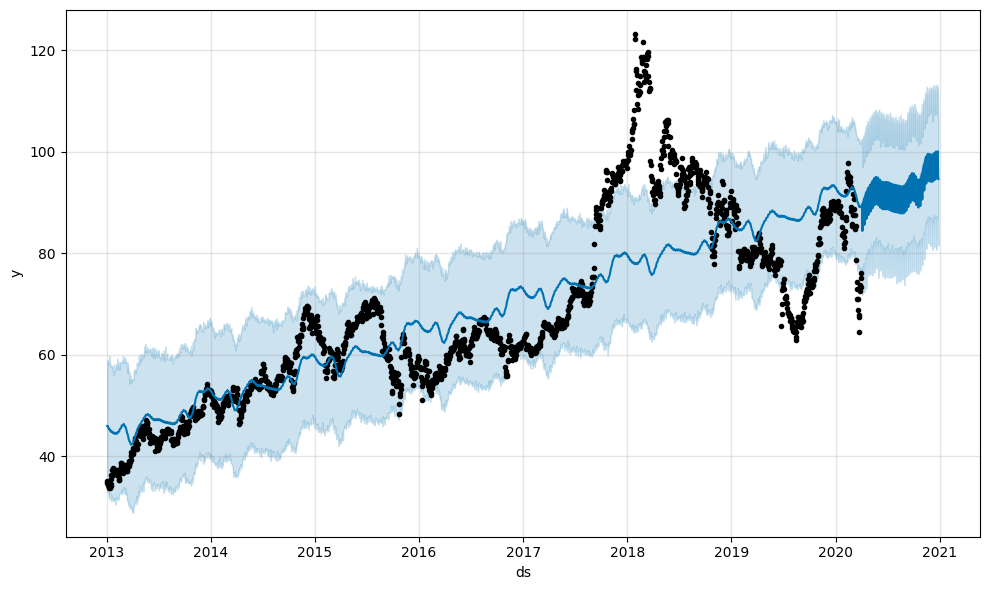

In [16]:
# changepoint_prior_scale = 0.001
# decreasing it will make the trend less flexible

m = Prophet(changepoint_prior_scale=0.001)
forecast = m.fit(ts).predict(future)
fig = m.plot(forecast)

# Specifying the locations of the changepoints

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5hu7go5/2ce5lz8c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5hu7go5/6oj7a1fe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85074', 'data', 'file=/tmp/tmpz5hu7go5/2ce5lz8c.json', 'init=/tmp/tmpz5hu7go5/6oj7a1fe.json', 'output', 'file=/tmp/tmpz5hu7go5/prophet_model8dqnidlg/prophet_model-20231006215606.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:56:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:56:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


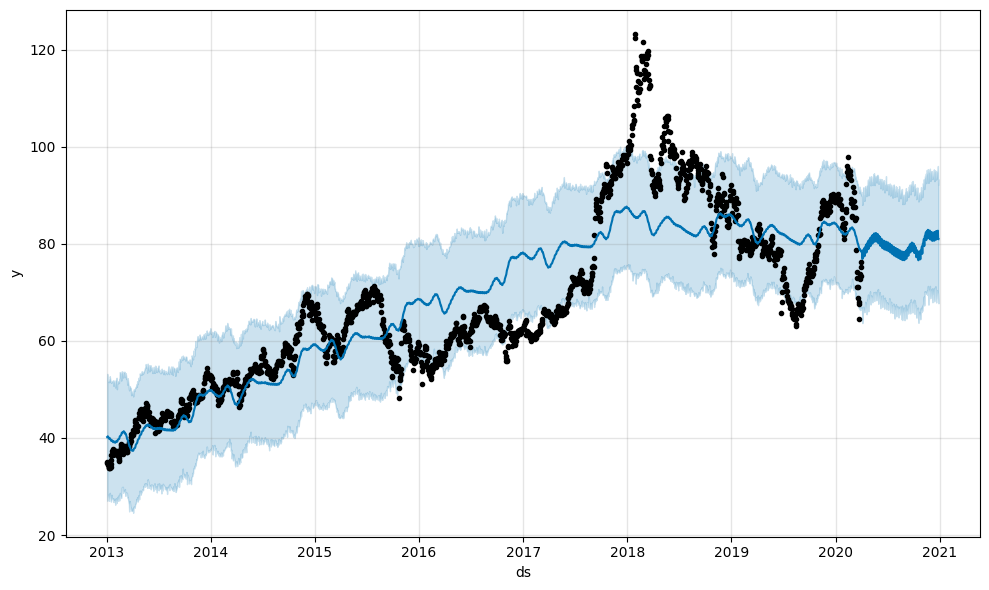

In [17]:
m = Prophet(changepoints=['2018-01'])
forecast = m.fit(ts).predict(future)
fig = m.plot(forecast)

# Cross Validation

In [26]:
df_validacao = pd.DataFrame(columns = (['modelo', 'MSE', 'MSE_std']))

## Prophet | Treino 1 ano | Horizon 22

In [27]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, period='365 days', horizon = '22 days')
display(df_cv.shape)
df_cv

INFO:prophet:Making 7 forecasts with cutoffs between 2014-03-12 00:00:00 and 2020-03-10 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5hu7go5/oq60mz6r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5hu7go5/_v50i0yj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48413', 'data', 'file=/tmp/tmpz5hu7go5/oq60mz6r.json', 'init=/tmp/tmpz5hu7go5/_v50i0yj.json', 'output', 'file=/tmp/tmpz5hu7go5/prophet_modelm5qfzvcu/prophet_model-20231006221114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:11:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:11:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5hu7go5/83msh27o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5hu7go5/bcd6u4a8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

(107, 6)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-03-13,51.553846,50.311641,52.679843,51.320000,2014-03-12
1,2014-03-14,51.752272,50.705502,52.898385,51.209999,2014-03-12
2,2014-03-17,51.771931,50.577896,52.978479,51.980000,2014-03-12
3,2014-03-18,52.027164,50.885334,53.155550,53.099998,2014-03-12
4,2014-03-19,52.006911,50.893481,53.161988,53.110001,2014-03-12
...,...,...,...,...,...,...
102,2020-03-26,80.403377,67.878755,92.525053,73.830002,2020-03-10
103,2020-03-27,80.432976,68.689439,93.161595,72.669998,2020-03-10
104,2020-03-30,79.955752,66.761452,92.741662,75.239998,2020-03-10
105,2020-03-31,79.735933,67.691621,92.268614,76.190002,2020-03-10


In [29]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
print('MSE médio: ', df_p.mse.mean())
print('MSE std: ', df_p.mse.std())
display(df_p)

df_validacao = df_validacao.append({'modelo': 'Prophet_Treino_365_Horizon_22',
                                    'MSE': np.round(df_p.mse.mean(),2),
                                    'MSE_std': np.round(df_p.mse.std(),2)},
                                    ignore_index=True)
df_validacao

MSE médio:  129.9458608008168
MSE std:  90.72227995812301


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,2 days,53.993601,7.348034,4.380709,0.057395,0.017394,0.053404,0.70
1,3 days,54.562130,7.386618,4.740559,0.063061,0.020927,0.058836,0.70
2,4 days,58.839577,7.670696,5.884859,0.080482,0.050015,0.075492,0.50
3,5 days,45.137993,6.718481,5.221201,0.072017,0.050015,0.067934,0.60
4,6 days,30.246867,5.499715,4.082311,0.061657,0.040844,0.058329,0.80
5,7 days,51.090124,7.147736,5.496398,0.083108,0.073751,0.077992,0.70
6,8 days,78.826127,8.878408,7.336459,0.097616,0.111416,0.091564,0.50
7,9 days,87.175012,9.336756,7.657853,0.093227,0.100556,0.087461,0.50
8,10 days,100.015200,10.000760,8.442732,0.106746,0.127971,0.099277,0.40
9,11 days,157.876579,12.564895,9.949327,0.126158,0.149305,0.115710,0.20


<ipython-input-29-3ca26be819f4>:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,modelo,MSE,MSE_std
0,Prophet_Treino_365_Horizon_22,129.95,90.72


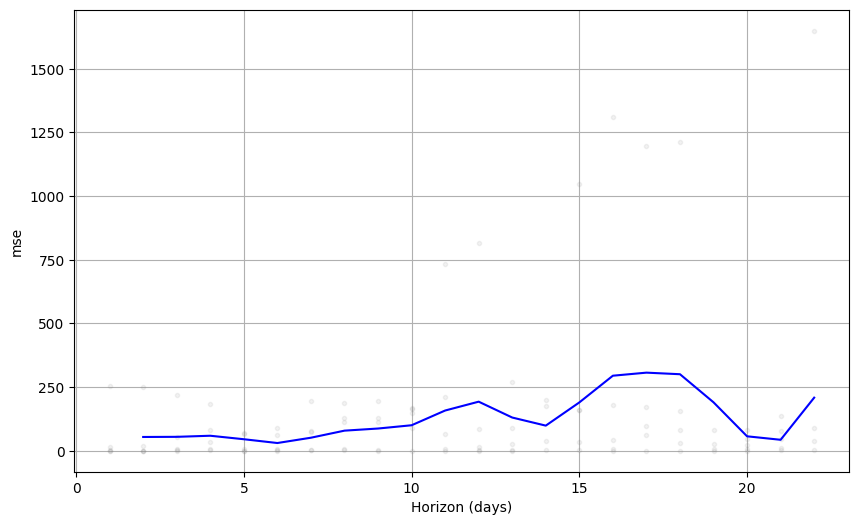

In [23]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mse')


## Prophet | Treino 3 meses | Horizon 5

In [30]:
df_cv = cross_validation(m, period='90 days', horizon = '5 days')
display(df_cv.shape)
df_cv

INFO:prophet:Making 26 forecasts with cutoffs between 2014-01-28 00:00:00 and 2020-03-27 00:00:00


  0%|          | 0/26 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5hu7go5/gwfjpqi_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5hu7go5/1a2pxrxz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23354', 'data', 'file=/tmp/tmpz5hu7go5/gwfjpqi_.json', 'init=/tmp/tmpz5hu7go5/1a2pxrxz.json', 'output', 'file=/tmp/tmpz5hu7go5/prophet_modeld0k0rtrm/prophet_model-20231006221153.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:11:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:11:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:11:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5hu7go5/fgh7cbxf.json
DE

(90, 6)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-01-29,50.561518,49.522790,51.786012,47.610001,2014-01-28
1,2014-01-30,50.670787,49.590002,51.698398,48.310001,2014-01-28
2,2014-01-31,50.899960,49.789837,51.954289,49.230000,2014-01-28
3,2014-04-29,54.796655,52.963462,56.639076,51.369999,2014-04-28
4,2014-04-30,55.006532,53.167982,56.942586,52.080002,2014-04-28
5,2014-05-01,55.336516,53.436361,57.191712,51.610001,2014-04-28
6,2014-05-02,55.782238,53.930111,57.662264,51.180000,2014-04-28
7,2014-07-28,55.310537,53.351826,57.357923,53.740002,2014-07-27
8,2014-07-29,55.504089,53.568506,57.451848,53.430000,2014-07-27
9,2014-07-30,55.554535,53.574211,57.655176,53.750000,2014-07-27


In [31]:
df_p = performance_metrics(df_cv)
print('MSE médio: ', df_p.mse.mean())
print('MSE std: ', df_p.mse.std())
display(df_p)

df_validacao = df_validacao.append({'modelo': 'Prophet_Treino_90_Horizon_5',
                                    'MSE': np.round(df_p.mse.mean(),2),
                                    'MSE_std': np.round(df_p.mse.std(),2)},
                                    ignore_index=True)
df_validacao

MSE médio:  113.8751199619903
MSE std:  16.33701073301241


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,98.458090,9.922605,7.708505,0.104853,0.073858,0.103312,0.500000
1,2 days,137.044156,11.706586,8.910460,0.120609,0.091417,0.116541,0.500000
2,3 days,115.779884,10.760106,8.139235,0.108772,0.079551,0.106357,0.578947
3,4 days,120.065990,10.957463,8.286561,0.103887,0.089647,0.102958,0.529412
4,5 days,98.027481,9.900883,7.234298,0.087902,0.073457,0.086376,0.722222


<ipython-input-31-46fe30b77743>:6: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,modelo,MSE,MSE_std
0,Prophet_Treino_365_Horizon_22,129.95,90.72
1,Prophet_Treino_90_Horizon_5,113.88,16.34
